#### Importing libraries

In [1]:
# !pip install imbalanced-learn
# pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import chi2, SelectKBest
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.datasets import make_classification

np.random.seed(1234)
import warnings
warnings.filterwarnings("ignore")

## Data Ingestion and Validation

In [3]:
df = pd.read_csv('Fraud.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.shape

(6362620, 11)

In [6]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
temp_columns = ['type','isFraud','isFlaggedFraud']
print("------------------------->> Values for each categorical feature & their value counts <<------------------------- ")
for i in temp_columns:
    print(df[i].value_counts())
    print("----------------------------")

------------------------->> Values for each categorical feature & their value counts <<------------------------- 
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
----------------------------
0    6354407
1       8213
Name: isFraud, dtype: int64
----------------------------
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64
----------------------------


In [8]:
df.isnull().sum().sum()

0

In [9]:
df.duplicated().sum()

0

In [10]:
# Hence we can conclude that data does not have any missing or duplicate values 

#### Studying insights obtained from the data :

In [11]:
count=0
for i, j in zip(df['isFraud'],df['isFlaggedFraud']):
    if(i==1 and j==1):
        count+=1
print(count)

# this indicates that is isFlaggedFraud is a very strong indicator of fraud transactions

16


In [12]:
df["isFraud"].value_counts(normalize=True)
# 99 % of the data is not fraud-transactions
# this indicates that the data is highly imbalanced

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [13]:
type_of_fraud_transaction = []
for i, j in zip(df['type'],df['isFraud']):
    if(j==1):
        type_of_fraud_transaction.append(i)
type_of_fraud_transaction = set(type_of_fraud_transaction)

print(type_of_fraud_transaction) 

# this indicates that only cashout and transfer transactions can be fraud transactions

{'CASH_OUT', 'TRANSFER'}


In [14]:
fraud_acc = []
for i, j in zip(df['nameDest'],df['isFraud']):
    if(j==1):
        fraud_acc.append(i)
fraud_acc = set(fraud_acc)
print(len(fraud_acc))

# This indicates that fraudsters have commited a fraud more than once using the same account.
# as total fraud transactions = 8213 & total fraud accounts = 8169

8169


In [15]:
count = 0
for i, j in zip(df['nameDest'],df['isFraud']):
    if((i in fraud_acc) and j==0):
        count+=1
print(count)
# Fraudulent accounts have also commited non fraud transactions : 
# Hence we can't identify a fraud transaction even if the recipient account is included in the fraud_acc list

57435


#### Outlier detection

<AxesSubplot:>

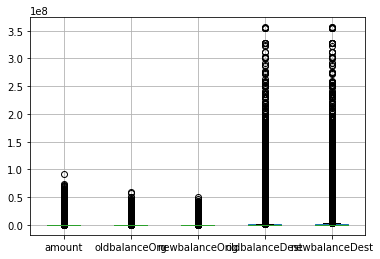

In [16]:
df.boxplot(return_type='axes',column = ['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest','newbalanceDest'])

In [17]:
# Method 1 of detecting outliers in a passed column of a dataframe
def outlier_count_1(data):
    outliers = []
    count = 0
    threshold = 3  #values farer from 3rd S.D. will be considered outliers
    mean = np.mean(data)
    std = np.std(data)
    
    for i in data:
        z_score = (i-mean)/std
        if np.abs(z_score)>threshold:
            outliers.append(i)
            count+=1
    print(count)

# Method 2
# only values below lower threshold and above upper threshold will be considered outliers
def outlier_count_2(data):
    lower_outliers = []
    upper_outliers = []
    count = 0
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lower_fence = q1-iqr*1.5
    upper_fence = q3+iqr*1.5
    
    for i in data:
        if(i<lower_fence):
            lower_outliers.append(i)
            count+=1
        elif(i>upper_fence):
            upper_outliers.append(i)
            count+=1
    print(count)

In [18]:
# create a function to get all outliers for int/float columns
outlier_count_1(df['amount'])

44945


In [19]:
outlier_count_2(df['amount'])

338078


#### Checking for multi-collinearity

In [20]:
X_variables = df[['step','amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,step,1.188500
1,amount,4.013501
2,oldbalanceOrg,465.124566
3,newbalanceOrig,466.906067
4,oldbalanceDest,71.790542
5,newbalanceDest,83.263477
6,isFlaggedFraud,1.000569


In [21]:
# as vif for ['oldbalanceOrg','newbalanceOrig','oldbalanceDest',newbalanceDest] is high, hence we conclude that there is high
# multi-collinearity among these variables
# VIF > 10 --> indicates high multi-collinearity

<AxesSubplot:>

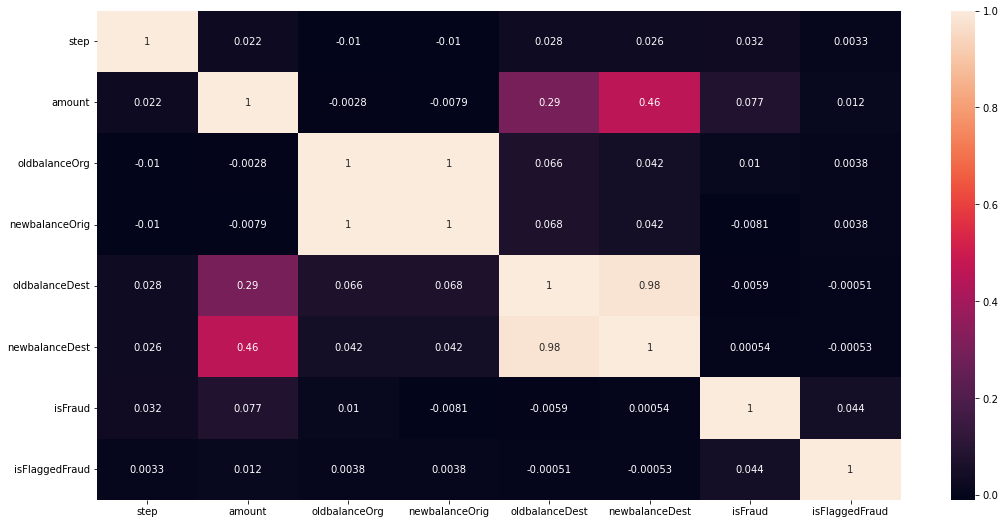

In [22]:
plt.figure(figsize=(18,9))
sns.heatmap(df.corr(),annot=True)

In [23]:
# Heatmap indicates presence of high multi-collinearity between :
# 1) oldbalanceOrg and newbalanceOrig  
# 2) oldbalanceDest and newbalanceDest

#### Identifying potential best numerical features

In [50]:
dummy_data = df.copy()
# dropping categorical features in dummmy data
dummy_data = dummy_data.drop(['nameOrig', 'nameDest','type'], axis=1)

X_dummy = dummy_data.drop("isFraud",axis=1)
y_dummy = dummy_data["isFraud"]
# selecting 6 best out of all numerical features
fs = SelectKBest(score_func=f_classif, k=6)
# apply feature selection
X_selected = fs.fit_transform(X_dummy, y_dummy)

cols = list(X_dummy.columns)
cols_selected = fs.get_feature_names_out(input_features=cols)
print("6 Best features")
print(cols_selected)


fs = SelectKBest(score_func=f_classif, k=3)
# apply feature selection
X_selected = fs.fit_transform(X_dummy, y_dummy)

cols = list(X_dummy.columns)
cols_selected = fs.get_feature_names_out(input_features=cols)
print("Top 3 Best features")
print(cols_selected)

['step' 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest'
 'isFlaggedFraud']
['step' 'amount' 'isFlaggedFraud']


In [25]:
# We observe that SelectKBest selects most appropriate columns which perfectly balance the tradeoff between 
# removing multicollinear data and keeping informative data

In [26]:
# HENCE : combining our knowledge from outlier detection, multi collinearity check & best feature identification
# we will keep the 8 best columns that will be selected by SelectKBest after one hot encoding & scaling the data

## Data preprocessing

In [27]:
# making a copy of data frame for safeguarding info
df_copy = df.copy()
df_copy.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [28]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [29]:
# Creating a function that returns split data along with best selected columns
def data_preprocessor(data):
    data = data.drop(["nameOrig","nameDest"],axis=1)
    data = pd.get_dummies(data,columns=['type'], drop_first=True)
#     print(data.head())
    X = data.drop("isFraud",axis=1)
    y = data["isFraud"]
    
    oversample = RandomOverSampler(sampling_strategy=0.1)
    X, y = oversample.fit_resample(X, y)
    undersample = RandomUnderSampler(sampling_strategy=0.5)
    X, y = undersample.fit_resample(X, y)
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
    
    scaler = preprocessing.RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    fs = SelectKBest(score_func=f_classif, k=8)
    X_train = fs.fit_transform(X_train, y_train)
    X_test = fs.transform(X_test)
    
    cols = list(X.columns)
    cols_selected = fs.get_feature_names_out(input_features=cols)
    
    return X_train,X_test,y_train,y_test,cols_selected

In [30]:
X_train,X_test,y_train,y_test,cols_selected = data_preprocessor(df)

In [31]:
print("List of selected columns : ",cols_selected)

List of selected columns :  ['step' 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest'
 'type_CASH_OUT' 'type_PAYMENT' 'type_TRANSFER']


In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1525056, 8)
(381264, 8)
(1525056,)
(381264,)


In [33]:
print(X_train[:2])

[[-6.78733032e-02  1.47831569e+00  2.80403694e+01  6.01094765e+02
   2.06819324e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.15384615e-01 -1.68885535e-01 -2.44702771e-02  4.94068643e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [34]:
print(y_train[:2])

3264321    0
1098945    0
Name: isFraud, dtype: int64


## Model Building

In [ ]:
# Creating 5 classification models as follows below of different algorithms & implement the one that gives maximum accuracy

#### Model 1

In [36]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
log_reg_pred = log_reg.predict(X_test)

#### Model 2

In [37]:
knn =  KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

#### Model 3

In [38]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

#### Model 4

In [39]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

#### Model 5

In [40]:
dtc =  DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

## Model Evaluation

In [41]:
def show_accuracy(y_true,y_pred):
    print("Accurate Predictions : ",accuracy_score(y_true,y_pred, normalize=False),"/",len(y_test))
    print("Accuracy Score : ",round(accuracy_score(y_true,y_pred),2))
    print("Confusion matrix : ")
    print(confusion_matrix(y_true,y_pred))
    print("Precision Score : ",round(precision_score(y_true, y_pred),2))
    print("Recall Score : ",round(recall_score(y_true, y_pred),2))
    print("F1 Score : ",round(f1_score(y_true, y_pred),2))

In [42]:
count_0 = 0
count_1 = 0
for i in y_test :
    if i==1:
        count_0+=1 
    elif i==0:
        count_1+=1 
print("Total No. of Not Fraud transactions in test data: ",count_0)
print("Total No. of Not Fraud transactions in test data:: ",count_1)
print("Total  transactions in test data:: ",count_0+count_1)

Total No. of Not Fraud transactions :  127314
Total No. of Not Fraud transactions :  253950
Total  transactions :  381264


In [43]:
print("----------------------LogisticRegression()----------------------")
show_accuracy(y_test,log_reg_pred)

----------------------LogisticRegression()----------------------
Accurate Predictions :  360491 / 381264
Accuracy Score :  0.95
Confusion matrix : 
[[246292   7658]
 [ 13115 114199]]
Precision Score :  0.94
Recall Score :  0.9
F1 Score :  0.92


In [44]:
print("----------------------KNeighborsClassifier()----------------------")
show_accuracy(y_test,knn_pred)

----------------------KNeighborsClassifier()----------------------
Accurate Predictions :  380574 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253260    690]
 [     0 127314]]
Precision Score :  0.99
Recall Score :  1.0
F1 Score :  1.0


In [45]:
print("----------------------RandomForestClassifier()----------------------")
show_accuracy(y_test,rfc_pred)

----------------------RandomForestClassifier()----------------------
Accurate Predictions :  381165 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253851     99]
 [     0 127314]]
Precision Score :  1.0
Recall Score :  1.0
F1 Score :  1.0


In [46]:
print("----------------------XGBClassifier()----------------------")
show_accuracy(y_test,xgb_pred)

----------------------XGBClassifier()----------------------
Accurate Predictions :  380966 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253652    298]
 [     0 127314]]
Precision Score :  1.0
Recall Score :  1.0
F1 Score :  1.0


In [47]:
print("----------------------DecisionTreeClassifier()----------------------")
show_accuracy(y_test,dtc_pred)

----------------------DecisionTreeClassifier()----------------------
Accurate Predictions :  381132 / 381264
Accuracy Score :  1.0
Confusion matrix : 
[[253818    132]
 [     0 127314]]
Precision Score :  1.0
Recall Score :  1.0
F1 Score :  1.0


## Hence by comparing each model's performance we can conclude that RandomForestClassifier() gives the highest accuracy

# > Key Questions and Answers

### 1. Data cleaning including missing values, outliers and multi-collinearity.
Data contained no missing values, lots of outlier data and multi collinear features. 
Outliers were handled by the use of Robust scaler that is not sensitive to outliers and scales them down without any information loss

### 2. Describe your fraud detection model in elaboration. 
Model takes in all input values, data preprocessing is needed for input data after which only those columns that we have used for model training and evaluation are kept rest all are discarded.

### 3. How did you select variables to be included in the model?
I have selected features by using an sklearn library SelectKBest which selects features according to the k highest scores.
It selects most appropriate columns which perfectly balance the tradeoff between removing multicollinear data and keeping informative data.

### 4. Demonstrate the performance of the model by using best set of tools. 
Model Evaluation provides a summary of best classification metrics as follows :
1) Accurate predictions / Total predictions  
2) Accuracy score  
3) Confusion matrix  
4) Precision  
5) Recall  
6) F1 score

### 5. What are the key factors that predict fraudulent customer? 
Following features are strong indicators of fraud transactions :
1) Step  
2) Amount  
3) isFlaggedFraud  

Apart from these, data suggests that only {'CASH_OUT', 'TRANSFER'} type of transactions can be fraudulent.

### 6. Do these factors make sense? If yes, How? If not, How not? 
These factors make complete sense. Each of as explained below :
1) Step  -> Time at which a fraudster is active can be repetative pattern observed by the data  

2) Amount  -> Target amount set by a fraudster should be in a particular range which justifies his motive to target specific accounts  

3) isFlaggedFraud  ->  Fishy patterns observed in the data by clerks entering the data of a transaction serve as a strong support to the argument of classifying fraudulent or non fraudulent transactions.

{'CASH_OUT', 'TRANSFER'} -> Unlike in Debit and Payment transactions, fraudsters can fraud a person by sending them faulty links which are made to commit the fraud attacks. Furthermore a fraud cashout transaction can be a one in which fraudster manages to use cheques to withdraw money in the name of the account owner.

### 7. What kind of prevention should be adopted while company update its infrastructure?
A few measures that i would suggest are as follows :
1) Data Encryption : Companies must encrypt their data so that no 3rd party in no hidden ways can access the data. If a fraudster has access to a persons account number and his bank balance, He would target those accounts to retrieve hefty amounts.

2) Multi Factor Authentication : Wherein only authorized users are given permissions to access the data and make changes to it with different levels of authority having different set of permission rules.

3) Fraud Prediction Algorithms : Machine Learning models, like the one built above must be deployed to predict fraud transactions that can alert us in advance and prevent mishap.

### 8. Assuming these actions have been implemented, how would you determine if they work?
To verify that above methods are effective, following can be done : 

1), 2) -> The effectiveness can be checked by hiring white hat hackers to try and find bugs and loopholes in existing system. Conducting routine Security audits & Penetration Tests would minimise chances of fraudulent transactions.

3) -> Deployed algorithms should be updated with newer data & its performance must be judged as efficient or updated if it needs any improvement